# Conditional Conv-VAE: MNIST & torch

[Refer](https://github.com/debtanu177/CVAE_MNIST/blob/master/train_cvae.py)

In [1]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER = PCI_BUS_ID
'''
Specify GPU(s) to be used here. Say you have 6 GPUs and you want to train Model A on 2 of them
and Model B on 4 of them. You can do that as follows-
CUDA_VISIBLE_DEVICES=0,1 python model_A.py
CUDA_VISIBLE_DEVICES=2,3,4,5 python model_B.py
'''
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn. functional as F
import torch.optim as optim

from tqdm import tqdm
from tqdm import trange
import os, pickle
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")
    
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 1.13.1
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA TITAN Xp
Available device is cuda


In [4]:
path_to_data = "/home/majumdar/Downloads/.data/"
batch_size = 512
num_epochs = 100

In [5]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
    # root = './data', train = True,
    root = path_to_data, train = True,
    transform = transforms_apply, download = True
)

test_dataset = torchvision.datasets.MNIST(
    # root = './data', train = False,
    root = path_to_data, train = False,
    transform = transforms_apply
)

In [6]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = batch_size,
    shuffle = False
)

In [7]:
print(f"Sizes of train_dataset: {len(train_dataset)} and test_dataet: {len(test_dataset)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

Sizes of train_dataset: 60000 and test_dataet: 10000
Sizes of train_loader: 118 and test_loader: 20
len(train_loader) = 118 & len(test_loader) = 20


(117.1875, 19.53125)

### Conditional Conv-VAE architecture

In [8]:
class Encoder(nn.Module):
    def __init__(
        self, latent_dim = 5,
        num_classes = 10
    ):
        super().__init__()
        self.latent_dimm = latent_dim
        self.num_classes = num_classes
    
        self.conv1 = nn.Conv2d(
            in_channels = 2, out_channels = 16,
            kernel_size = 5, stride = 2,
            bias = True
        )
        self.conv2 = nn.Conv2d(
            in_channels = 16, out_channels = 32,
            kernel_size = 5, stride = 2
        )
        self.linear = nn.Linear(in_features = 4 * 4 * 32, out_features = 300)
    
    
    def forward(self, x, y):
        # label = np.zeros((x.size(0), self.num_classes))
        # label[np.arange(x.shape[0]), y] = 1
        # label = torch.from_numpy(label)
        label = torch.zeros(x.size(0), self.num_classes)
        label[torch.arange(x.size(0)), y] = 1.0

        y_t = torch.argmax(label, dim = 1).reshape((label.shape[0], 1, 1, 1))
        y_t = (torch.ones(x.shape) * y_t).to(device)

        # print(f"y_t.device:{y_t.device}, x.device: {x.device}")
        x_t = torch.cat((x, y_t), dim = 1)
        
        out = F.leaky_relu(self.conv1(x_t))
        out = F.leaky_relu(self.conv2(out))
        return F.leaky_relu(self.linear(out.view(out.size(0), -1)))


In [9]:
class Decoder(nn.Module):
    def __init__(
        self, latent_dim = 5,
        num_classes = 10
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        self.linear = nn.Linear(in_features = latent_dim + num_classes, out_features = 300)
        self.linear2 = nn.Linear(in_features = 300, out_features = 4 * 4 * 32)
        self.conv = nn.ConvTranspose2d(32, 16, kernel_size = 5,stride = 2)
        self.conv2 = nn.ConvTranspose2d(16, 1, kernel_size = 5, stride = 2)
        self.conv3 = nn.ConvTranspose2d(1, 1, kernel_size = 4)
        
        
    def forward(self, z, y):
        
        label = torch.zeros(y.size(0), self.num_classes).to(device)
        label[torch.arange(y.size(0)), y] = 1.0

        z = torch.cat((z, label.float()), dim = 1).to(device)
        
        out = F.leaky_relu(self.linear(z))
        out = F.leaky_relu(self.linear2(out))

        # Reshape before inputting to Conv2dtranspose-
        out = out.view(out.size(0), 32, 4, 4)

        out = F.leaky_relu(self.conv(out))
        out = F.leaky_relu(self.conv2(out))
        out = torch.sigmoid(self.conv3(out))

        return out


In [10]:
class ConditionalVAE(nn.Module):
    def __init__(
        self, latent_dim = 5,
        num_classes = 10
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        self.encoder = Encoder(latent_dim = self.latent_dim)
        self.decoder = Decoder(latent_dim = self.latent_dim)
        
        self.mu = nn.Linear(in_features = 300, out_features = self.latent_dim)
        self.logvar = nn.Linear(in_features = 300, out_features = self.latent_dim)


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(device)
        return (eps * std) + mu


    def forward(self, x, y):
    
        # Get embedded representation for input-
        out = self.encoder(x, y)
        
        # Get mean and log-var embeddings for encoded input-
        mu_embed = self.mu(out)
        logvar_embed = self.logvar(out)
        
        # Get reparameterized 'z'-
        z = self.reparameterize(mu = mu_embed, logvar = logvar_embed)
        
        # Synthesize a new output-
        x_synth = self.decoder(z, y)
        
        return x_synth, mu_embed, logvar_embed


In [11]:
# Specify latent space/dimensions-
latent_dim = 5

num_classes = 10

In [12]:
# Initialize Conditional Conv-VAE model-
model = ConditionalVAE(latent_dim = latent_dim, num_classes = num_classes).to(device)

In [13]:
def count_params(model):
    # Count number of layer-wise parameters and total parameters-
    tot_params = 0
    for param in model.parameters():
        # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
        tot_params += param.nelement()
    
    return tot_params

print(f"Conditional Conv-VAE model has {count_params(model = model)} params")

Conditional Conv-VAE model has 342704 params


In [14]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [15]:
def compute_loss(data, data_recon, mu, log_var, alpha = 1, beta = 1):
    '''
    Function to compute loss = reconstruction loss * reconstruction_term_weight + KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. mu: mean from the latent vector
    2. logvar: log variance from the latent vector
    3. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss - reconstruction term weight
    4. data: training data
    5. data_recon: VAE's reconstructed data
    '''
    
    # Sum over latent dimensions-
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var), axis = 1)
    # kl_div = -0.5 * torch.sum(1 + log_var - (mu **2) - torch.exp(log_var), axis = 1)
    
    # kl_div.shape
    # torch.Size([32])
    
    batchsize = kl_div.size(0)

    # Average over batch dimension-
    kl_div = kl_div.mean()
    
    reconstruction_loss_fn = F.mse_loss
    recon_loss = reconstruction_loss_fn(data_recon, data, reduction = 'none')
    
    # recon_loss.shape
    # torch.Size([32, 1, 28, 28])
    
    # Sum over all pixels-
    recon_loss = recon_loss.view(batchsize, -1).sum(axis = 1)
    
    # recon_loss.shape
    # torch.Size([32])
    
    # Average over mini-batch dimension-
    recon_loss = recon_loss.mean()
    
    final_loss = (alpha * recon_loss) + (beta * kl_div)
    
    return final_loss, recon_loss, kl_div


In [ ]:
'''
# Alternative cost computation-
recon_loss = F.mse_loss(x_synth, x, reduction = 'sum')
kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
'''

In [16]:
def train_one_epoch(model, dataloader, dataset, alpha, beta):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    # Initialize variables to keep track of 3 losses-
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    
    for i, data in tqdm(
        enumerate(dataloader),
        total = int(len(dataset) / dataloader.batch_size)
        ):
      
        x = data[0]
        y = data[1]
        
        # Push to 'device'-
        x = x.to(device)
        y = y.to(device)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        x_recon, mu, logvar = model(x, y)
        
        final_loss, recon_loss, kl_div_loss = compute_loss(
            data = x, data_recon = x_recon,
            mu = mu, log_var = logvar,
            alpha = alpha, beta = beta
        )
        
        # Update losses-
        running_final_loss += final_loss.item()
        running_kl_loss += kl_div_loss.cpu().detach().numpy()
        running_recon_loss += recon_loss.cpu().detach().numpy()
        
        # Compute gradients wrt total loss-
        final_loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
    
    # Compute losses as float values-
    train_loss = running_final_loss / len(dataloader.dataset)
    kl_loss = running_kl_loss / len(dataloader.dataset)
    recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return train_loss, kl_loss, recon_loss


def test_one_epoch(model, dataloader, dataset, alpha, beta):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            total = int(len(dataset) / dataloader.batch_size)
        ):
            
            x_v = data[0]
            y_v = data[1]
            
            # Push data points to 'device'-
            x_v = x_v.to(device)
            y_v = y_v.to(device)
            
            # Forward propagation-
            x_recon, mu, logvar = model(x_v, y_v)
            
            final_loss, recon_loss, kl_div_loss = compute_loss(
                data = x_v, data_recon = x_recon,
                mu = mu, log_var = logvar,
                alpha = alpha, beta = beta
            )
        
            # Update losses-
            running_final_loss += final_loss.item()
            running_kl_loss += kl_div_loss.cpu().detach().numpy()
            running_recon_loss += recon_loss.cpu().detach().numpy()
            
                
    test_loss = running_final_loss / len(dataloader.dataset)
    test_kl_loss = running_kl_loss / len(dataloader.dataset)
    test_recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return test_loss, test_kl_loss, test_recon_loss


In [17]:
# Specify alpha - Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
alpha = 1
beta = 1

In [18]:
# Python dict to contain training metrics-
train_history = {}

# Initialize parameters for Early Stopping manual implementation-
best_test_loss = 10000

In [19]:
for epoch in range(1, num_epochs + 1):
    
    train_loss, kl_train_loss, recon_train_loss = train_one_epoch(
        model = model, dataloader = train_loader,
        dataset = train_dataset,
        alpha = alpha, beta = beta
    )
    
    test_loss, test_kl_loss, test_recon_loss = test_one_epoch(
        model = model, dataloader = test_loader,
        dataset = test_dataset, 
        alpha = alpha, beta = beta
    )
    
    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss,
        'train_recon_loss': kl_train_loss,
        'train_kl_loss': kl_train_loss,
        'test_loss': test_loss,
        'test_recon_loss': test_recon_loss,
        'test_kl_loss': test_kl_loss
    }
    
    print(f"Epoch = {epoch}; loss = {train_loss:.4f}",
          f", kl-loss = {kl_train_loss:.4f}, recon loss = {recon_train_loss:.4f}",
          f", test loss = {test_loss:.4f}, test kl-loss = {test_kl_loss:.4f}",
          f" & test recon loss = {test_recon_loss:.4f}"
         )
    
    
    # Code for manual Early Stopping:
    if (test_loss < best_test_loss):
    
        # update variable to lowest loss encountered so far-
        best_test_loss = test_loss
        
        print(f"Saving model with lowest val_loss = {test_loss:.4f}\n")
        torch.save(model.state_dict(), "Conditional_ConvVAE_MNIST_best_model.pth")


118it [00:12,  9.38it/s]                                                                                                                                    
20it [00:01, 11.61it/s]                                                                                                                                     


Epoch = 1; loss = 1.5025 , kl-loss = 0.0175, recon loss = 1.4849 , test loss = 1.2643, test kl-loss = 0.0237  & test recon loss = 1.2406
Saving model with lowest val_loss = 1.2643



118it [00:11, 10.72it/s]                                                                                                                                    
20it [00:01, 11.61it/s]                                                                                                                                     


Epoch = 2; loss = 1.1682 , kl-loss = 0.0208, recon loss = 1.1474 , test loss = 1.1426, test kl-loss = 0.0217  & test recon loss = 1.1209
Saving model with lowest val_loss = 1.1426



118it [00:10, 10.79it/s]                                                                                                                                    
20it [00:01, 11.58it/s]                                                                                                                                     


Epoch = 3; loss = 1.0829 , kl-loss = 0.0208, recon loss = 1.0620 , test loss = 1.0801, test kl-loss = 0.0202  & test recon loss = 1.0599
Saving model with lowest val_loss = 1.0801



118it [00:10, 10.87it/s]                                                                                                                                    
20it [00:01, 11.46it/s]                                                                                                                                     


Epoch = 4; loss = 1.0433 , kl-loss = 0.0209, recon loss = 1.0224 , test loss = 1.0538, test kl-loss = 0.0205  & test recon loss = 1.0333
Saving model with lowest val_loss = 1.0538



118it [00:10, 10.79it/s]                                                                                                                                    
20it [00:01, 11.52it/s]                                                                                                                                     


Epoch = 5; loss = 1.0237 , kl-loss = 0.0210, recon loss = 1.0027 , test loss = 1.0407, test kl-loss = 0.0207  & test recon loss = 1.0200
Saving model with lowest val_loss = 1.0407



118it [00:10, 10.74it/s]                                                                                                                                    
20it [00:01, 11.54it/s]                                                                                                                                     


Epoch = 6; loss = 1.0032 , kl-loss = 0.0210, recon loss = 0.9822 , test loss = 1.0120, test kl-loss = 0.0222  & test recon loss = 0.9898
Saving model with lowest val_loss = 1.0120



118it [00:10, 10.84it/s]                                                                                                                                    
20it [00:01, 11.55it/s]                                                                                                                                     


Epoch = 7; loss = 0.9825 , kl-loss = 0.0213, recon loss = 0.9612 , test loss = 0.9880, test kl-loss = 0.0209  & test recon loss = 0.9671
Saving model with lowest val_loss = 0.9880



118it [00:10, 10.90it/s]                                                                                                                                    
20it [00:01, 11.51it/s]                                                                                                                                     


Epoch = 8; loss = 0.9277 , kl-loss = 0.0214, recon loss = 0.9063 , test loss = 0.9396, test kl-loss = 0.0222  & test recon loss = 0.9174
Saving model with lowest val_loss = 0.9396



118it [00:10, 10.94it/s]                                                                                                                                    
20it [00:01, 11.70it/s]                                                                                                                                     


Epoch = 9; loss = 0.9123 , kl-loss = 0.0216, recon loss = 0.8906 , test loss = 0.9296, test kl-loss = 0.0220  & test recon loss = 0.9076
Saving model with lowest val_loss = 0.9296



118it [00:10, 10.88it/s]                                                                                                                                    
20it [00:01, 10.96it/s]                                                                                                                                     


Epoch = 10; loss = 0.9051 , kl-loss = 0.0217, recon loss = 0.8833 , test loss = 0.9266, test kl-loss = 0.0217  & test recon loss = 0.9049
Saving model with lowest val_loss = 0.9266



118it [00:10, 10.93it/s]                                                                                                                                    
20it [00:01, 11.66it/s]                                                                                                                                     


Epoch = 11; loss = 0.9019 , kl-loss = 0.0217, recon loss = 0.8802 , test loss = 0.9208, test kl-loss = 0.0218  & test recon loss = 0.8990
Saving model with lowest val_loss = 0.9208



118it [00:10, 10.87it/s]                                                                                                                                    
20it [00:01, 11.53it/s]                                                                                                                                     


Epoch = 12; loss = 0.8969 , kl-loss = 0.0219, recon loss = 0.8750 , test loss = 0.9176, test kl-loss = 0.0228  & test recon loss = 0.8948
Saving model with lowest val_loss = 0.9176



118it [00:10, 10.91it/s]                                                                                                                                    
20it [00:01, 11.39it/s]                                                                                                                                     


Epoch = 13; loss = 0.8935 , kl-loss = 0.0219, recon loss = 0.8716 , test loss = 0.9160, test kl-loss = 0.0216  & test recon loss = 0.8945
Saving model with lowest val_loss = 0.9160



118it [00:10, 10.97it/s]                                                                                                                                    
20it [00:01, 11.54it/s]                                                                                                                                     


Epoch = 14; loss = 0.8925 , kl-loss = 0.0219, recon loss = 0.8706 , test loss = 0.9126, test kl-loss = 0.0226  & test recon loss = 0.8900
Saving model with lowest val_loss = 0.9126



118it [00:13,  8.84it/s]                                                                                                                                    
20it [00:02,  9.30it/s]                                                                                                                                     


Epoch = 15; loss = 0.8895 , kl-loss = 0.0219, recon loss = 0.8677 , test loss = 0.9107, test kl-loss = 0.0213  & test recon loss = 0.8894
Saving model with lowest val_loss = 0.9107



118it [00:13,  8.65it/s]                                                                                                                                    
20it [00:02,  9.30it/s]                                                                                                                                     


Epoch = 16; loss = 0.8875 , kl-loss = 0.0219, recon loss = 0.8656 , test loss = 0.9098, test kl-loss = 0.0223  & test recon loss = 0.8874
Saving model with lowest val_loss = 0.9098



118it [00:13,  8.67it/s]                                                                                                                                    
20it [00:02,  9.28it/s]                                                                                                                                     


Epoch = 17; loss = 0.8853 , kl-loss = 0.0219, recon loss = 0.8634 , test loss = 0.9072, test kl-loss = 0.0222  & test recon loss = 0.8851
Saving model with lowest val_loss = 0.9072



118it [00:13,  8.65it/s]                                                                                                                                    
20it [00:02,  9.34it/s]                                                                                                                                     


Epoch = 18; loss = 0.8842 , kl-loss = 0.0220, recon loss = 0.8623 , test loss = 0.9066, test kl-loss = 0.0218  & test recon loss = 0.8848
Saving model with lowest val_loss = 0.9066



118it [00:13,  8.58it/s]                                                                                                                                    
20it [00:02,  9.36it/s]                                                                                                                                     


Epoch = 19; loss = 0.8831 , kl-loss = 0.0219, recon loss = 0.8611 , test loss = 0.9077, test kl-loss = 0.0225  & test recon loss = 0.8852


118it [00:13,  8.62it/s]                                                                                                                                    
20it [00:01, 11.25it/s]                                                                                                                                     


Epoch = 20; loss = 0.8822 , kl-loss = 0.0219, recon loss = 0.8603 , test loss = 0.9046, test kl-loss = 0.0225  & test recon loss = 0.8821
Saving model with lowest val_loss = 0.9046



118it [00:11, 10.62it/s]                                                                                                                                    
20it [00:01, 11.51it/s]                                                                                                                                     


Epoch = 21; loss = 0.8802 , kl-loss = 0.0220, recon loss = 0.8582 , test loss = 0.9023, test kl-loss = 0.0221  & test recon loss = 0.8802
Saving model with lowest val_loss = 0.9023



118it [00:10, 10.81it/s]                                                                                                                                    
20it [00:01, 11.51it/s]                                                                                                                                     


Epoch = 22; loss = 0.8791 , kl-loss = 0.0220, recon loss = 0.8571 , test loss = 0.9030, test kl-loss = 0.0226  & test recon loss = 0.8804


118it [00:11, 10.65it/s]                                                                                                                                    
20it [00:01, 11.58it/s]                                                                                                                                     


Epoch = 23; loss = 0.8789 , kl-loss = 0.0220, recon loss = 0.8570 , test loss = 0.9024, test kl-loss = 0.0223  & test recon loss = 0.8801


118it [00:10, 10.82it/s]                                                                                                                                    
20it [00:01, 11.54it/s]                                                                                                                                     


Epoch = 24; loss = 0.8782 , kl-loss = 0.0220, recon loss = 0.8562 , test loss = 0.9016, test kl-loss = 0.0216  & test recon loss = 0.8800
Saving model with lowest val_loss = 0.9016



118it [00:10, 10.81it/s]                                                                                                                                    
20it [00:01, 11.55it/s]                                                                                                                                     


Epoch = 25; loss = 0.8770 , kl-loss = 0.0220, recon loss = 0.8550 , test loss = 0.9008, test kl-loss = 0.0221  & test recon loss = 0.8787
Saving model with lowest val_loss = 0.9008



118it [00:10, 10.85it/s]                                                                                                                                    
20it [00:01, 11.65it/s]                                                                                                                                     


Epoch = 26; loss = 0.8758 , kl-loss = 0.0220, recon loss = 0.8538 , test loss = 0.9001, test kl-loss = 0.0225  & test recon loss = 0.8776
Saving model with lowest val_loss = 0.9001



118it [00:10, 10.80it/s]                                                                                                                                    
20it [00:01, 11.73it/s]                                                                                                                                     


Epoch = 27; loss = 0.8752 , kl-loss = 0.0221, recon loss = 0.8532 , test loss = 0.8986, test kl-loss = 0.0225  & test recon loss = 0.8762
Saving model with lowest val_loss = 0.8986



118it [00:10, 10.92it/s]                                                                                                                                    
20it [00:01, 11.66it/s]                                                                                                                                     


Epoch = 28; loss = 0.8750 , kl-loss = 0.0220, recon loss = 0.8530 , test loss = 0.8983, test kl-loss = 0.0226  & test recon loss = 0.8757
Saving model with lowest val_loss = 0.8983



118it [00:10, 10.85it/s]                                                                                                                                    
20it [00:01, 11.55it/s]                                                                                                                                     


Epoch = 29; loss = 0.8744 , kl-loss = 0.0221, recon loss = 0.8524 , test loss = 0.8976, test kl-loss = 0.0229  & test recon loss = 0.8746
Saving model with lowest val_loss = 0.8976



118it [00:10, 10.93it/s]                                                                                                                                    
20it [00:01, 11.73it/s]                                                                                                                                     


Epoch = 30; loss = 0.8729 , kl-loss = 0.0221, recon loss = 0.8508 , test loss = 0.8968, test kl-loss = 0.0223  & test recon loss = 0.8745
Saving model with lowest val_loss = 0.8968



118it [00:10, 10.81it/s]                                                                                                                                    
20it [00:01, 11.72it/s]                                                                                                                                     


Epoch = 31; loss = 0.8728 , kl-loss = 0.0220, recon loss = 0.8507 , test loss = 0.8985, test kl-loss = 0.0223  & test recon loss = 0.8762


118it [00:10, 10.83it/s]                                                                                                                                    
20it [00:01, 11.63it/s]                                                                                                                                     


Epoch = 32; loss = 0.8725 , kl-loss = 0.0220, recon loss = 0.8505 , test loss = 0.8960, test kl-loss = 0.0218  & test recon loss = 0.8742
Saving model with lowest val_loss = 0.8960



118it [00:10, 10.90it/s]                                                                                                                                    
20it [00:01, 11.70it/s]                                                                                                                                     


Epoch = 33; loss = 0.8717 , kl-loss = 0.0221, recon loss = 0.8496 , test loss = 0.8951, test kl-loss = 0.0225  & test recon loss = 0.8726
Saving model with lowest val_loss = 0.8951



118it [00:10, 10.90it/s]                                                                                                                                    
20it [00:01, 11.48it/s]                                                                                                                                     


Epoch = 34; loss = 0.8721 , kl-loss = 0.0221, recon loss = 0.8500 , test loss = 0.8981, test kl-loss = 0.0224  & test recon loss = 0.8757


118it [00:10, 10.88it/s]                                                                                                                                    
20it [00:01, 10.95it/s]                                                                                                                                     


Epoch = 35; loss = 0.8707 , kl-loss = 0.0221, recon loss = 0.8487 , test loss = 0.8946, test kl-loss = 0.0220  & test recon loss = 0.8727
Saving model with lowest val_loss = 0.8946



118it [00:10, 10.79it/s]                                                                                                                                    
20it [00:01, 11.52it/s]                                                                                                                                     


Epoch = 36; loss = 0.8706 , kl-loss = 0.0220, recon loss = 0.8486 , test loss = 0.8943, test kl-loss = 0.0220  & test recon loss = 0.8723
Saving model with lowest val_loss = 0.8943



118it [00:10, 10.85it/s]                                                                                                                                    
20it [00:01, 11.62it/s]                                                                                                                                     


Epoch = 37; loss = 0.8700 , kl-loss = 0.0221, recon loss = 0.8479 , test loss = 0.8942, test kl-loss = 0.0221  & test recon loss = 0.8721
Saving model with lowest val_loss = 0.8942



118it [00:13,  8.92it/s]                                                                                                                                    
20it [00:02,  9.29it/s]                                                                                                                                     


Epoch = 38; loss = 0.8702 , kl-loss = 0.0220, recon loss = 0.8481 , test loss = 0.8956, test kl-loss = 0.0225  & test recon loss = 0.8730


118it [00:13,  8.73it/s]                                                                                                                                    
20it [00:02,  9.33it/s]                                                                                                                                     


Epoch = 39; loss = 0.8694 , kl-loss = 0.0220, recon loss = 0.8474 , test loss = 0.8936, test kl-loss = 0.0223  & test recon loss = 0.8713
Saving model with lowest val_loss = 0.8936



118it [00:13,  8.64it/s]                                                                                                                                    
20it [00:02,  9.25it/s]                                                                                                                                     


Epoch = 40; loss = 0.8690 , kl-loss = 0.0221, recon loss = 0.8469 , test loss = 0.8941, test kl-loss = 0.0225  & test recon loss = 0.8716


118it [00:13,  8.68it/s]                                                                                                                                    
20it [00:02,  9.31it/s]                                                                                                                                     


Epoch = 41; loss = 0.8687 , kl-loss = 0.0220, recon loss = 0.8466 , test loss = 0.8927, test kl-loss = 0.0221  & test recon loss = 0.8706
Saving model with lowest val_loss = 0.8927



118it [00:13,  8.73it/s]                                                                                                                                    
20it [00:02,  9.28it/s]                                                                                                                                     


Epoch = 42; loss = 0.8689 , kl-loss = 0.0221, recon loss = 0.8468 , test loss = 0.8930, test kl-loss = 0.0223  & test recon loss = 0.8707


118it [00:13,  8.69it/s]                                                                                                                                    
20it [00:02,  9.27it/s]                                                                                                                                     


Epoch = 43; loss = 0.8678 , kl-loss = 0.0221, recon loss = 0.8457 , test loss = 0.8929, test kl-loss = 0.0219  & test recon loss = 0.8710


118it [00:13,  8.62it/s]                                                                                                                                    
20it [00:02,  9.29it/s]                                                                                                                                     


Epoch = 44; loss = 0.8682 , kl-loss = 0.0220, recon loss = 0.8462 , test loss = 0.8927, test kl-loss = 0.0224  & test recon loss = 0.8703
Saving model with lowest val_loss = 0.8927



118it [00:13,  8.72it/s]                                                                                                                                    
20it [00:02,  9.32it/s]                                                                                                                                     


Epoch = 45; loss = 0.8674 , kl-loss = 0.0221, recon loss = 0.8452 , test loss = 0.8926, test kl-loss = 0.0225  & test recon loss = 0.8701
Saving model with lowest val_loss = 0.8926



118it [00:13,  8.70it/s]                                                                                                                                    
20it [00:02,  9.27it/s]                                                                                                                                     


Epoch = 46; loss = 0.8680 , kl-loss = 0.0221, recon loss = 0.8459 , test loss = 0.8921, test kl-loss = 0.0217  & test recon loss = 0.8704
Saving model with lowest val_loss = 0.8921



118it [00:13,  8.72it/s]                                                                                                                                    
20it [00:02,  9.29it/s]                                                                                                                                     


Epoch = 47; loss = 0.8671 , kl-loss = 0.0220, recon loss = 0.8451 , test loss = 0.8928, test kl-loss = 0.0229  & test recon loss = 0.8699


118it [00:13,  8.63it/s]                                                                                                                                    
20it [00:02,  9.08it/s]                                                                                                                                     


Epoch = 48; loss = 0.8667 , kl-loss = 0.0221, recon loss = 0.8447 , test loss = 0.8919, test kl-loss = 0.0225  & test recon loss = 0.8695
Saving model with lowest val_loss = 0.8919



118it [00:13,  8.67it/s]                                                                                                                                    
20it [00:02,  9.30it/s]                                                                                                                                     


Epoch = 49; loss = 0.8659 , kl-loss = 0.0221, recon loss = 0.8438 , test loss = 0.8915, test kl-loss = 0.0219  & test recon loss = 0.8696
Saving model with lowest val_loss = 0.8915



118it [00:13,  8.64it/s]                                                                                                                                    
20it [00:02,  9.33it/s]                                                                                                                                     


Epoch = 50; loss = 0.8662 , kl-loss = 0.0220, recon loss = 0.8441 , test loss = 0.8912, test kl-loss = 0.0221  & test recon loss = 0.8691
Saving model with lowest val_loss = 0.8912



118it [00:13,  8.72it/s]                                                                                                                                    
20it [00:02,  9.32it/s]                                                                                                                                     


Epoch = 51; loss = 0.8657 , kl-loss = 0.0221, recon loss = 0.8436 , test loss = 0.8911, test kl-loss = 0.0218  & test recon loss = 0.8693
Saving model with lowest val_loss = 0.8911



118it [00:13,  8.55it/s]                                                                                                                                    
20it [00:02,  9.25it/s]                                                                                                                                     


Epoch = 52; loss = 0.8658 , kl-loss = 0.0221, recon loss = 0.8437 , test loss = 0.8913, test kl-loss = 0.0229  & test recon loss = 0.8684


118it [00:13,  8.59it/s]                                                                                                                                    
20it [00:02,  9.29it/s]                                                                                                                                     


Epoch = 53; loss = 0.8657 , kl-loss = 0.0221, recon loss = 0.8437 , test loss = 0.8923, test kl-loss = 0.0230  & test recon loss = 0.8693


118it [00:13,  8.59it/s]                                                                                                                                    
20it [00:02,  9.24it/s]                                                                                                                                     


Epoch = 54; loss = 0.8649 , kl-loss = 0.0221, recon loss = 0.8428 , test loss = 0.8909, test kl-loss = 0.0224  & test recon loss = 0.8685
Saving model with lowest val_loss = 0.8909



118it [00:13,  8.66it/s]                                                                                                                                    
20it [00:02,  9.33it/s]                                                                                                                                     


Epoch = 55; loss = 0.8657 , kl-loss = 0.0221, recon loss = 0.8436 , test loss = 0.8916, test kl-loss = 0.0220  & test recon loss = 0.8696


118it [00:11, 10.36it/s]                                                                                                                                    
20it [00:01, 11.52it/s]                                                                                                                                     


Epoch = 56; loss = 0.8644 , kl-loss = 0.0221, recon loss = 0.8423 , test loss = 0.8899, test kl-loss = 0.0223  & test recon loss = 0.8676
Saving model with lowest val_loss = 0.8899



118it [00:10, 10.84it/s]                                                                                                                                    
20it [00:01, 11.73it/s]                                                                                                                                     


Epoch = 57; loss = 0.8652 , kl-loss = 0.0221, recon loss = 0.8431 , test loss = 0.8896, test kl-loss = 0.0223  & test recon loss = 0.8673
Saving model with lowest val_loss = 0.8896



118it [00:10, 10.89it/s]                                                                                                                                    
20it [00:01, 11.66it/s]                                                                                                                                     


Epoch = 58; loss = 0.8643 , kl-loss = 0.0221, recon loss = 0.8422 , test loss = 0.8909, test kl-loss = 0.0227  & test recon loss = 0.8682


118it [00:10, 10.84it/s]                                                                                                                                    
20it [00:01, 11.55it/s]                                                                                                                                     


Epoch = 59; loss = 0.8639 , kl-loss = 0.0221, recon loss = 0.8418 , test loss = 0.8893, test kl-loss = 0.0220  & test recon loss = 0.8673
Saving model with lowest val_loss = 0.8893



118it [00:11, 10.57it/s]                                                                                                                                    
20it [00:01, 11.54it/s]                                                                                                                                     


Epoch = 60; loss = 0.8637 , kl-loss = 0.0221, recon loss = 0.8415 , test loss = 0.8896, test kl-loss = 0.0220  & test recon loss = 0.8676


118it [00:10, 10.80it/s]                                                                                                                                    
20it [00:01, 11.56it/s]                                                                                                                                     


Epoch = 61; loss = 0.8638 , kl-loss = 0.0221, recon loss = 0.8417 , test loss = 0.8900, test kl-loss = 0.0223  & test recon loss = 0.8678


118it [00:10, 10.79it/s]                                                                                                                                    
20it [00:01, 11.53it/s]                                                                                                                                     


Epoch = 62; loss = 0.8636 , kl-loss = 0.0221, recon loss = 0.8416 , test loss = 0.8903, test kl-loss = 0.0224  & test recon loss = 0.8679


118it [00:11, 10.70it/s]                                                                                                                                    
20it [00:01, 11.47it/s]                                                                                                                                     


Epoch = 63; loss = 0.8635 , kl-loss = 0.0221, recon loss = 0.8415 , test loss = 0.8900, test kl-loss = 0.0221  & test recon loss = 0.8679


118it [00:10, 10.78it/s]                                                                                                                                    
20it [00:01, 10.89it/s]                                                                                                                                     


Epoch = 64; loss = 0.8632 , kl-loss = 0.0221, recon loss = 0.8411 , test loss = 0.8897, test kl-loss = 0.0223  & test recon loss = 0.8674


118it [00:10, 10.85it/s]                                                                                                                                    
20it [00:01, 11.66it/s]                                                                                                                                     


Epoch = 65; loss = 0.8633 , kl-loss = 0.0221, recon loss = 0.8412 , test loss = 0.8890, test kl-loss = 0.0226  & test recon loss = 0.8664
Saving model with lowest val_loss = 0.8890



118it [00:10, 10.89it/s]                                                                                                                                    
20it [00:01, 11.62it/s]                                                                                                                                     


Epoch = 66; loss = 0.8629 , kl-loss = 0.0221, recon loss = 0.8408 , test loss = 0.8894, test kl-loss = 0.0226  & test recon loss = 0.8668


118it [00:10, 10.86it/s]                                                                                                                                    
20it [00:01, 11.64it/s]                                                                                                                                     


Epoch = 67; loss = 0.8630 , kl-loss = 0.0221, recon loss = 0.8409 , test loss = 0.8898, test kl-loss = 0.0225  & test recon loss = 0.8673


118it [00:10, 10.83it/s]                                                                                                                                    
20it [00:01, 11.63it/s]                                                                                                                                     


Epoch = 68; loss = 0.8626 , kl-loss = 0.0221, recon loss = 0.8405 , test loss = 0.8892, test kl-loss = 0.0227  & test recon loss = 0.8665


118it [00:11, 10.72it/s]                                                                                                                                    
20it [00:01, 11.57it/s]                                                                                                                                     


Epoch = 69; loss = 0.8626 , kl-loss = 0.0221, recon loss = 0.8405 , test loss = 0.8892, test kl-loss = 0.0220  & test recon loss = 0.8673


118it [00:10, 10.77it/s]                                                                                                                                    
20it [00:01, 11.55it/s]                                                                                                                                     


Epoch = 70; loss = 0.8623 , kl-loss = 0.0222, recon loss = 0.8401 , test loss = 0.8889, test kl-loss = 0.0220  & test recon loss = 0.8669
Saving model with lowest val_loss = 0.8889



118it [00:10, 10.79it/s]                                                                                                                                    
20it [00:01, 11.63it/s]                                                                                                                                     


Epoch = 71; loss = 0.8625 , kl-loss = 0.0221, recon loss = 0.8404 , test loss = 0.8909, test kl-loss = 0.0219  & test recon loss = 0.8690


118it [00:10, 10.81it/s]                                                                                                                                    
20it [00:01, 11.62it/s]                                                                                                                                     


Epoch = 72; loss = 0.8620 , kl-loss = 0.0221, recon loss = 0.8399 , test loss = 0.8881, test kl-loss = 0.0219  & test recon loss = 0.8662
Saving model with lowest val_loss = 0.8881



118it [00:11, 10.62it/s]                                                                                                                                    
20it [00:01, 11.58it/s]                                                                                                                                     


Epoch = 73; loss = 0.8623 , kl-loss = 0.0221, recon loss = 0.8401 , test loss = 0.8898, test kl-loss = 0.0225  & test recon loss = 0.8673


118it [00:10, 10.83it/s]                                                                                                                                    
20it [00:01, 11.50it/s]                                                                                                                                     


Epoch = 74; loss = 0.8615 , kl-loss = 0.0221, recon loss = 0.8394 , test loss = 0.8885, test kl-loss = 0.0226  & test recon loss = 0.8659


118it [00:11, 10.71it/s]                                                                                                                                    
20it [00:01, 11.58it/s]                                                                                                                                     


Epoch = 75; loss = 0.8615 , kl-loss = 0.0222, recon loss = 0.8393 , test loss = 0.8885, test kl-loss = 0.0227  & test recon loss = 0.8658


118it [00:10, 10.82it/s]                                                                                                                                    
20it [00:01, 11.56it/s]                                                                                                                                     


Epoch = 76; loss = 0.8620 , kl-loss = 0.0222, recon loss = 0.8398 , test loss = 0.8887, test kl-loss = 0.0229  & test recon loss = 0.8658


118it [00:10, 10.80it/s]                                                                                                                                    
20it [00:01, 11.66it/s]                                                                                                                                     


Epoch = 77; loss = 0.8618 , kl-loss = 0.0221, recon loss = 0.8397 , test loss = 0.8893, test kl-loss = 0.0223  & test recon loss = 0.8670


118it [00:10, 10.93it/s]                                                                                                                                    
20it [00:01, 11.70it/s]                                                                                                                                     


Epoch = 78; loss = 0.8612 , kl-loss = 0.0222, recon loss = 0.8391 , test loss = 0.8880, test kl-loss = 0.0224  & test recon loss = 0.8656
Saving model with lowest val_loss = 0.8880



118it [00:13,  8.82it/s]                                                                                                                                    
20it [00:02,  9.12it/s]                                                                                                                                     


Epoch = 79; loss = 0.8608 , kl-loss = 0.0221, recon loss = 0.8387 , test loss = 0.8887, test kl-loss = 0.0223  & test recon loss = 0.8664


118it [00:13,  8.56it/s]                                                                                                                                    
20it [00:02,  9.19it/s]                                                                                                                                     


Epoch = 80; loss = 0.8608 , kl-loss = 0.0222, recon loss = 0.8386 , test loss = 0.8879, test kl-loss = 0.0223  & test recon loss = 0.8656
Saving model with lowest val_loss = 0.8879



118it [00:13,  8.62it/s]                                                                                                                                    
20it [00:02,  9.28it/s]                                                                                                                                     


Epoch = 81; loss = 0.8609 , kl-loss = 0.0222, recon loss = 0.8387 , test loss = 0.8883, test kl-loss = 0.0221  & test recon loss = 0.8662


118it [00:13,  8.60it/s]                                                                                                                                    
20it [00:02,  9.18it/s]                                                                                                                                     


Epoch = 82; loss = 0.8612 , kl-loss = 0.0221, recon loss = 0.8391 , test loss = 0.8879, test kl-loss = 0.0222  & test recon loss = 0.8656
Saving model with lowest val_loss = 0.8879



118it [00:13,  8.56it/s]                                                                                                                                    
20it [00:02,  9.22it/s]                                                                                                                                     


Epoch = 83; loss = 0.8610 , kl-loss = 0.0222, recon loss = 0.8389 , test loss = 0.8884, test kl-loss = 0.0225  & test recon loss = 0.8659


118it [00:11, 10.29it/s]                                                                                                                                    
20it [00:01, 11.54it/s]                                                                                                                                     


Epoch = 84; loss = 0.8604 , kl-loss = 0.0221, recon loss = 0.8383 , test loss = 0.8918, test kl-loss = 0.0221  & test recon loss = 0.8697


118it [00:11, 10.67it/s]                                                                                                                                    
20it [00:01, 11.59it/s]                                                                                                                                     


Epoch = 85; loss = 0.8606 , kl-loss = 0.0221, recon loss = 0.8385 , test loss = 0.8875, test kl-loss = 0.0224  & test recon loss = 0.8651
Saving model with lowest val_loss = 0.8875



118it [00:10, 10.77it/s]                                                                                                                                    
20it [00:01, 11.56it/s]                                                                                                                                     


Epoch = 86; loss = 0.8604 , kl-loss = 0.0222, recon loss = 0.8382 , test loss = 0.8876, test kl-loss = 0.0218  & test recon loss = 0.8658


118it [00:10, 10.79it/s]                                                                                                                                    
20it [00:01, 11.56it/s]                                                                                                                                     


Epoch = 87; loss = 0.8599 , kl-loss = 0.0222, recon loss = 0.8377 , test loss = 0.8879, test kl-loss = 0.0225  & test recon loss = 0.8655


118it [00:10, 10.77it/s]                                                                                                                                    
20it [00:01, 11.64it/s]                                                                                                                                     


Epoch = 88; loss = 0.8597 , kl-loss = 0.0222, recon loss = 0.8375 , test loss = 0.8867, test kl-loss = 0.0227  & test recon loss = 0.8640
Saving model with lowest val_loss = 0.8867



118it [00:10, 10.81it/s]                                                                                                                                    
20it [00:01, 10.88it/s]                                                                                                                                     


Epoch = 89; loss = 0.8602 , kl-loss = 0.0222, recon loss = 0.8380 , test loss = 0.8868, test kl-loss = 0.0224  & test recon loss = 0.8644


118it [00:10, 10.92it/s]                                                                                                                                    
20it [00:01, 11.73it/s]                                                                                                                                     


Epoch = 90; loss = 0.8594 , kl-loss = 0.0221, recon loss = 0.8372 , test loss = 0.8872, test kl-loss = 0.0224  & test recon loss = 0.8647


118it [00:10, 10.98it/s]                                                                                                                                    
20it [00:01, 11.73it/s]                                                                                                                                     


Epoch = 91; loss = 0.8595 , kl-loss = 0.0222, recon loss = 0.8373 , test loss = 0.8888, test kl-loss = 0.0223  & test recon loss = 0.8664


118it [00:10, 10.85it/s]                                                                                                                                    
20it [00:01, 11.65it/s]                                                                                                                                     


Epoch = 92; loss = 0.8593 , kl-loss = 0.0222, recon loss = 0.8372 , test loss = 0.8875, test kl-loss = 0.0229  & test recon loss = 0.8645


118it [00:10, 10.90it/s]                                                                                                                                    
20it [00:01, 11.62it/s]                                                                                                                                     


Epoch = 93; loss = 0.8595 , kl-loss = 0.0222, recon loss = 0.8373 , test loss = 0.8864, test kl-loss = 0.0222  & test recon loss = 0.8642
Saving model with lowest val_loss = 0.8864



118it [00:10, 10.77it/s]                                                                                                                                    
20it [00:01, 11.58it/s]                                                                                                                                     


Epoch = 94; loss = 0.8588 , kl-loss = 0.0222, recon loss = 0.8366 , test loss = 0.8869, test kl-loss = 0.0229  & test recon loss = 0.8640


118it [00:10, 10.86it/s]                                                                                                                                    
20it [00:01, 11.58it/s]                                                                                                                                     


Epoch = 95; loss = 0.8586 , kl-loss = 0.0222, recon loss = 0.8363 , test loss = 0.8864, test kl-loss = 0.0218  & test recon loss = 0.8646
Saving model with lowest val_loss = 0.8864



118it [00:10, 10.85it/s]                                                                                                                                    
20it [00:01, 11.61it/s]                                                                                                                                     


Epoch = 96; loss = 0.8589 , kl-loss = 0.0223, recon loss = 0.8367 , test loss = 0.8860, test kl-loss = 0.0223  & test recon loss = 0.8637
Saving model with lowest val_loss = 0.8860



118it [00:10, 10.87it/s]                                                                                                                                    
20it [00:01, 11.60it/s]                                                                                                                                     


Epoch = 97; loss = 0.8583 , kl-loss = 0.0222, recon loss = 0.8360 , test loss = 0.8873, test kl-loss = 0.0221  & test recon loss = 0.8651


118it [00:10, 10.76it/s]                                                                                                                                    
20it [00:01, 11.65it/s]                                                                                                                                     


Epoch = 98; loss = 0.8585 , kl-loss = 0.0222, recon loss = 0.8363 , test loss = 0.8865, test kl-loss = 0.0217  & test recon loss = 0.8647


118it [00:10, 10.88it/s]                                                                                                                                    
20it [00:01, 11.65it/s]                                                                                                                                     


Epoch = 99; loss = 0.8583 , kl-loss = 0.0222, recon loss = 0.8361 , test loss = 0.8863, test kl-loss = 0.0226  & test recon loss = 0.8637


118it [00:10, 10.91it/s]                                                                                                                                    
20it [00:01, 11.63it/s]                                                                                                                                     

Epoch = 100; loss = 0.8580 , kl-loss = 0.0222, recon loss = 0.8357 , test loss = 0.8857, test kl-loss = 0.0219  & test recon loss = 0.8637
Saving model with lowest val_loss = 0.8857



In [20]:
# Save training history as pickle file-
with open("Conditional_ConvVAE_MNIST_train_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

### Training Visualizations

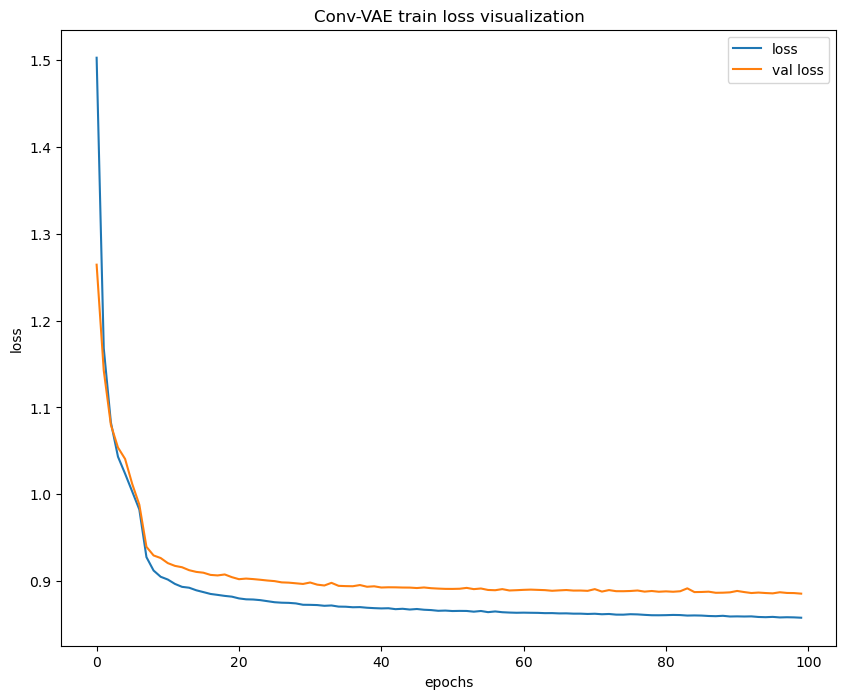

In [21]:
plt.figure(figsize = (10, 8))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'loss')
plt.plot([train_history[e]['test_loss'] for e in train_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Conv-VAE train loss visualization")
plt.legend(loc = 'best')
plt.show()

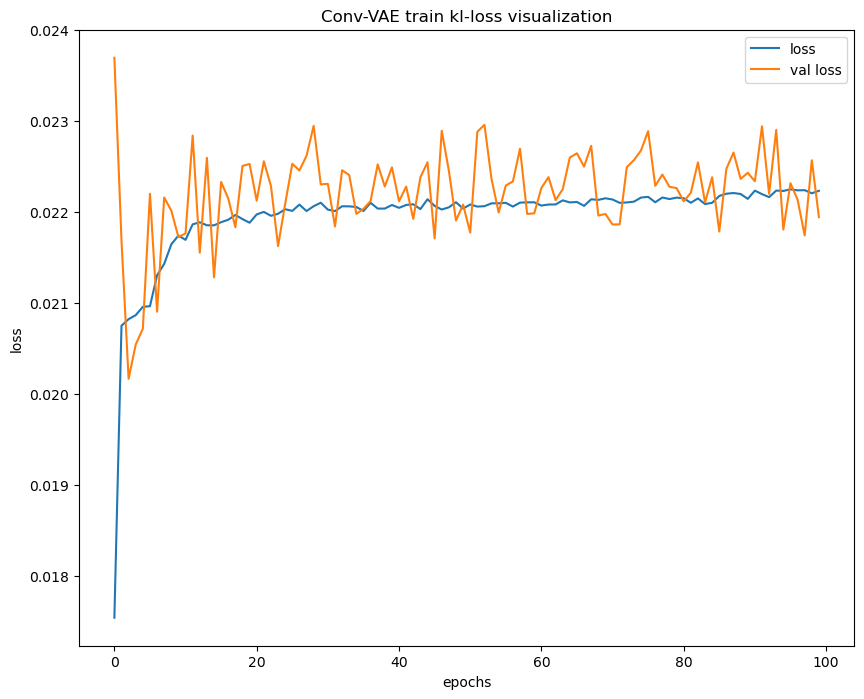

In [22]:
plt.figure(figsize = (10, 8))
plt.plot([train_history[e]['train_kl_loss'] for e in train_history.keys()], label = 'loss')
plt.plot([train_history[e]['test_kl_loss'] for e in train_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Conv-VAE train kl-loss visualization")
plt.legend(loc = 'best')
plt.show()

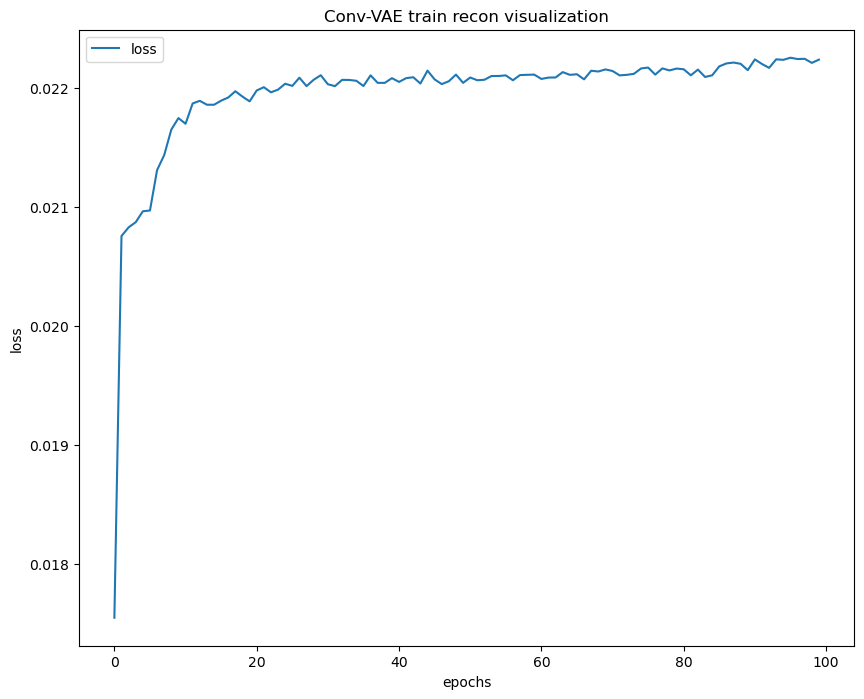

In [24]:
plt.figure(figsize = (10, 8))
plt.plot([train_history[e]['train_recon_loss'] for e in train_history.keys()], label = 'loss')
# plt.plot([train_history[e]['test_recon_loss'] for e in train_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Conv-VAE train recon visualization")
plt.legend(loc = 'best')
plt.show()

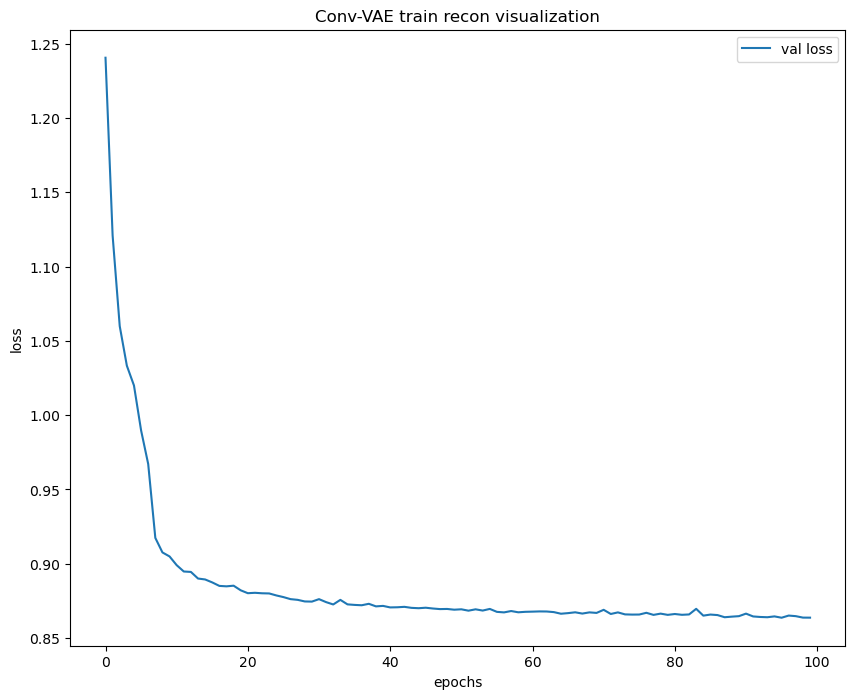

In [25]:
plt.figure(figsize = (10, 8))
plt.plot([train_history[e]['test_recon_loss'] for e in train_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Conv-VAE train recon visualization")
plt.legend(loc = 'best')
plt.show()

In [ ]:
del model

In [ ]:
# Load trained weights from before-
# trained_model = ConditionalVAE(latent_dim = latent_dim, num_classes = num_classes).to(device)
# trained_model.load_state_dict(torch.load('Conditional_ConvVAE_MNIST_best_model.pth', map_location = torch.device('cpu')))
# trained_model.load_state_dict(torch.load('Conditional_ConvVAE_MNIST_best_model.pth'))

In [30]:
def synthesize_images(model, label = 2, batch_size = 128, latent_dim = 5):
    # Synthesize new MNIST images using trained 'model'.
    
    z = torch.randn(batch_size, latent_dim).to(device)
    y = torch.from_numpy(np.asarray([label] * batch_size)).to(device)
    
    # Synthesize new output-
    x_synth = model.decoder(z, y).detach().cpu().numpy()
    
    return np.transpose(a = x_synth, axes = (0, 2, 3, 1))


In [31]:
# Specify class/digit to synthesize-
label = 7

x_synth = synthesize_images(
    model = model, label = label,
    batch_size = batch_size, latent_dim = latent_dim
)

In [32]:
x_synth.shape

(512, 28, 28, 1)

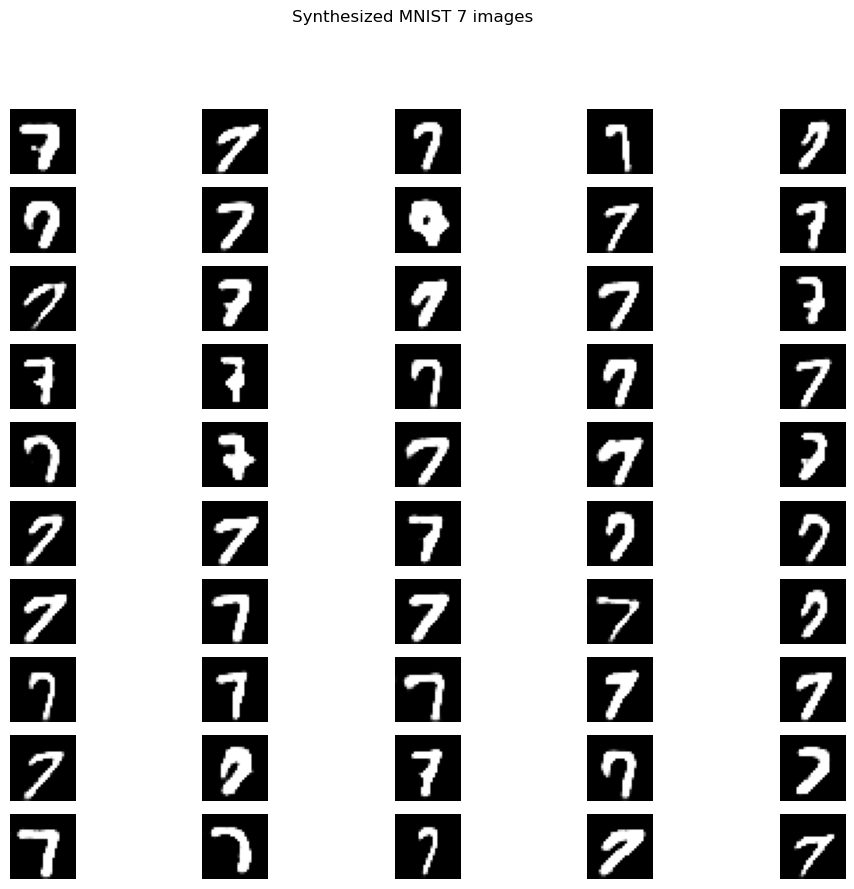

In [33]:
# Visualize synthesized images using trained VAE-
plt.figure(figsize = (12, 10))
for i in range(50):
    # 10 rows & 5 columns-
    plt.subplot(10, 5, i + 1)
    plt.imshow(x_synth[i], cmap = 'gray')
    plt.axis('off')
    
plt.suptitle(f"Synthesized MNIST {label} images")
plt.show()

In [34]:
# Specify class/digit to synthesize-
label = 3

x_synth = synthesize_images(
    model = model, label = label,
    batch_size = batch_size, latent_dim = latent_dim
)

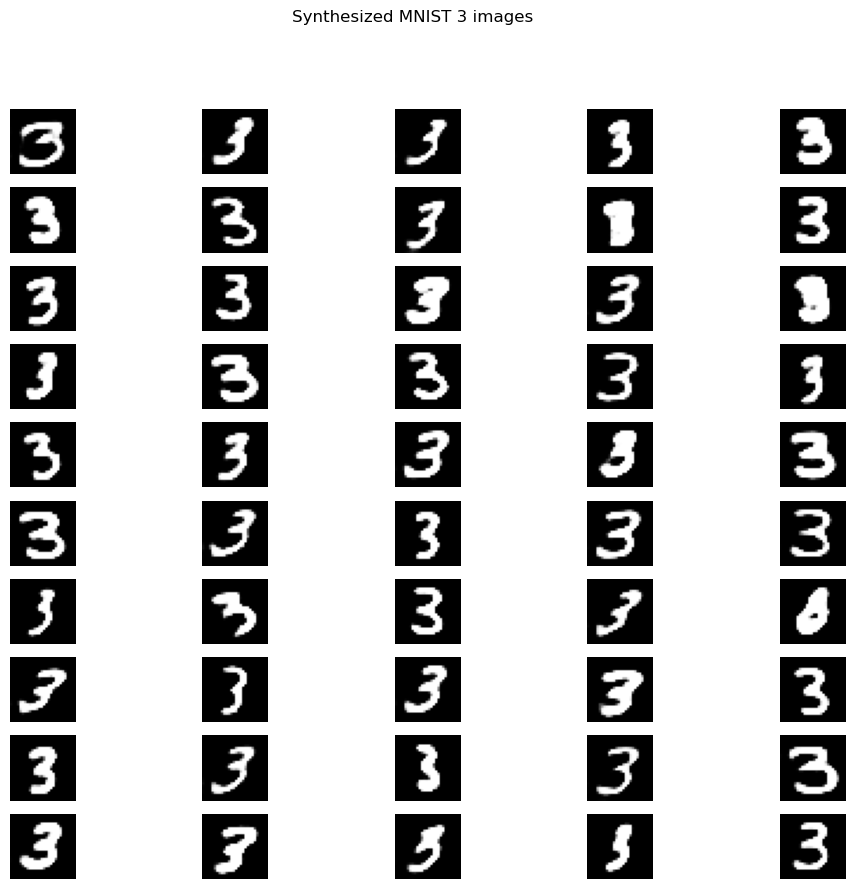

In [35]:
# Visualize synthesized images using trained VAE-
plt.figure(figsize = (12, 10))
for i in range(50):
    # 10 rows & 5 columns-
    plt.subplot(10, 5, i + 1)
    plt.imshow(x_synth[i], cmap = 'gray')
    plt.axis('off')
    
plt.suptitle(f"Synthesized MNIST {label} images")
plt.show()

In [36]:
# Specify class/digit to synthesize-
label = 2

x_synth = synthesize_images(
    model = model, label = label,
    batch_size = batch_size, latent_dim = latent_dim
)

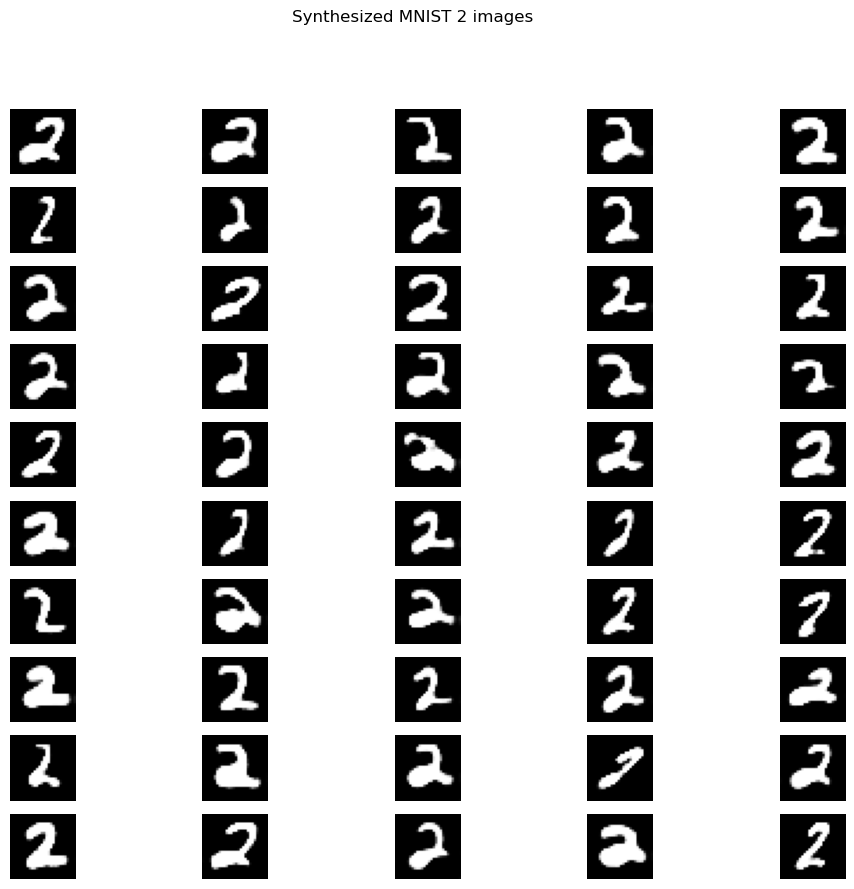

In [37]:
# Visualize synthesized images using trained VAE-
plt.figure(figsize = (12, 10))
for i in range(50):
    # 10 rows & 5 columns-
    plt.subplot(10, 5, i + 1)
    plt.imshow(x_synth[i], cmap = 'gray')
    plt.axis('off')
    
plt.suptitle(f"Synthesized MNIST {label} images")
plt.show()